<a href="https://colab.research.google.com/github/EJH22/MSc-TranslationalNeuroscience-Module3/blob/main/MNISTRotate_w/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as torchdata
import numpy as np

import matplotlib.pyplot as plt

import typing
import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_ds_MNIST = torchvision.datasets.MNIST(
    root='./data',
    train=True, 
    transform=transforms.Compose(
        [
            torchvision.transforms.ToTensor(), # turns PIL to tensor
            #torchvision.transforms.Normalize((0.5), (0.5)), # normalises the tensor
            #lambda x: x.view(-1),
        ]
    ),
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 413935794.95it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24909663.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 131445839.45it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 19990061.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class MNISTRotate(torchdata.Dataset):
    def __init__(self, dataset, rotation):
        self.dataset = dataset
        self.rotation = rotation
    
    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        return transforms.functional.rotate(img, angle=self.rotation), target
    
    def __len__(self):
        return len(self.dataset)

In [6]:
class MNISTTaskRotate(torchdata.Dataset):
    def __init__(self, dataset:torchdata.Dataset, rotations:typing.List[float]):
        self.dataset = dataset
        self.rotations = rotations

        self.task_datasets = []
        self.task_indices = []

        for rotation in rotations:
            self.task_datasets.append(MNISTRotate(dataset, rotation))
            self.task_indices.append(len(self.task_datasets[-1]))#This makes sure it iterates through the dataset and stopping one before the end

        self.task_indices = np.cumsum(self.task_indices)

    def __getitem__(self, idx):
        # get current task
        task_idx = (idx >= self.task_indices).sum()
        # get task dataset
        task_dataset = self.task_datasets[task_idx]
        # get index on that task dataset
        task_dataset_idx = idx - self.task_indices[task_idx]
        # return data
        img, target = task_dataset[task_dataset_idx]
        return img, target, task_idx

    def __len__(self):
        return np.sum([len(ds) for ds in self.task_datasets])


In [7]:
class MNISTTaskRotate(torchdata.Dataset):
    def __init__(self, dataset:torchdata.Dataset, rotations:typing.List[float]):
        self.dataset = dataset
        self.rotations = rotations

        self.task_datasets = []
        self.task_indices = []

        for rotation in rotations:
            self.task_datasets.append(MNISTRotate(dataset, rotation))
            self.task_indices.append(len(self.task_datasets[-1]))#This makes sure it itereates through the dataset and stopping one before the end

        self.task_indices = np.cumsum(self.task_indices)

        #self.task_datasets = [
        #    MNISTRotate(dataset, rotation) for rotation in rotations
        #]

    def __getitem__(self, idx):
        # get current task
        task_idx = (idx >= self.task_indices).sum()
        # get task dataset
        task_dataset = self.task_datasets[task_idx]
        # get index on that task dataset
        task_dataset_idx = idx - self.task_indices[task_idx]
        # return data
        return [t for t in task_dataset[task_dataset_idx]] + [task_idx]

    def __len__(self):
        return np.sum([len(ds) for ds in self.task_datasets])


In [8]:
rotation_list = np.arange(0, 390, 30).astype(float) #This goes from 0 to 360 in steps of 30

In [9]:
train_rotate_ds = MNISTTaskRotate(train_ds_MNIST, rotation_list) # using custom dataset containing many rotated datasets
train_rotate_dl = torchdata.DataLoader(train_rotate_ds, batch_size=64, shuffle=False)

In [10]:
class MNISTRotate(torchdata.Dataset):
    def __init__(self, dataset, rotation, unreliable_source):
        self.dataset = dataset
        self.rotation = rotation
        self.unreliable_source = unreliable_source
        self.source_list = np.random.choice(10, size=(len(dataset)))

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        source = self.source_list[idx]
        if source in self.unreliable_source:
        #    img = transforms.functional.rotate(img, angle=self.rotation) + torch.randn_like(img) * 0.1 # add noise
            img =  torch.randn_like(img) * 0.1 # replace with noise
        else:
            img = transforms.functional.rotate(img, angle=self.rotation)
        return img.view(-1), source, target
    
    def __len__(self):
        return len(self.dataset)

In [11]:
# list of dataloaders containing many rotated datasets
train_dls = [
    torchdata.DataLoader(
        MNISTRotate(
            train_ds_MNIST, 
            rotation=rotation,
            unreliable_source=[0,1,2,3]
        ),
        batch_size=1024, 
        shuffle=False
    ) for rotation in rotation_list
]

In [12]:
for train_dl in train_dls:
    for batch in tqdm.tqdm(train_dl):
        pass
    break

100%|██████████| 59/59 [00:20<00:00,  2.87it/s]


In [13]:
for batch in tqdm.tqdm(train_rotate_dl):
    pass 

100%|██████████| 12188/12188 [06:07<00:00, 33.16it/s]


In [14]:
batch[0].shape

torch.Size([32, 1, 28, 28])

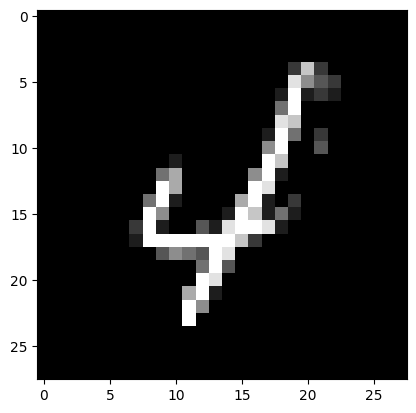

In [15]:
plt.imshow(batch[0][7].numpy()[0,:,:], cmap='gray')

In [19]:
import torch.nn as nn
import torch.optim as optim

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.fc2 = nn.Linear(128, 10)  # Assuming a 10-class classification problem

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example input: Batch of size [32, 1, 28, 28]
inputs = batch[0].to(device)
model = model.to(device)

# Forward pass
outputs = model(inputs)
    

In [ ]:
from tqdm import tqdm

num_epochs = 10
#model = model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(tqdm(train_rotate_dl, total=len(train_rotate_dl))):
        inputs, labels, task_idx = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_rotate_dl)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')



 41%|████      | 4962/12188 [02:43<04:40, 25.75it/s]